In [1]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

x_test = np.load('/home/jovyan/MQTTset/x_test.npy')
x_train = np.load('/home/jovyan/MQTTset/x_train.npy')
x_val = np.load('/home/jovyan/MQTTset/x_val.npy')
y_test = np.load('/home/jovyan/MQTTset/y_test.npy')
y_train = np.load('/home/jovyan/MQTTset/y_train.npy')
y_val = np.load('/home/jovyan/MQTTset/y_val.npy')

In [3]:
# gnb_org = GaussianNB()
# gnb_org.fit(x_train, y_train)
# y_pred_org = gnb_org.predict(x_test)

# accuracy_gnb = accuracy_score(y_test, y_pred_org)
# micro_f1_gnb = f1_score_rep(y_test, y_pred_org, average="micro")
# macro_f1_gnb = f1_score_rep(y_test, y_pred_org, average="macro")

# print(f'Gaussian Naive Bayes Test Accuracy: {accuracy_gnb * 100:.2f}%')
# print(f'Gaussian Naive Bayes Micro F1 Score: {micro_f1_gnb}')
# print(f'Gaussian Naive Bayes Macro F1 Score: {macro_f1_gnb}')

In [4]:



# 定义参数
gnb_params = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_gnb(x_train, y_train, param_grid):
    gnb = GaussianNB()

    start = time()
    halving_gnb_results = HalvingGridSearchCV(
        gnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_gnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_gnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_gnb(x_val, y_val, gnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 GNB 模型
best_gnb = GaussianNB(**best_params)
best_gnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_gnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_gnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_gnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


     iter  rank_test_score  mean_test_score  \
200     6                3         0.758325   
199     6                5         0.758131   
198     5                1         0.758805   
197     5                2         0.758585   
196     5                4         0.758160   

                                        params  
200                   {'var_smoothing': 1e-09}  
199  {'var_smoothing': 1.2328467394420635e-09}  
198                   {'var_smoothing': 1e-09}  
197  {'var_smoothing': 1.2328467394420635e-09}  
196   {'var_smoothing': 1.519911082952933e-09}  
Best score for HalvingGridSearchCV is 0.758, took 19.34 seconds
Params: {'var_smoothing': 1e-09}
Corresponding test accuracy: 67.09%
Micro F1 Score:  0.670863128210293
Macro F1 Score:  0.601206348089561


FPR: [3.41693087e-01 2.19221763e-03 4.43969084e-04 1.08759139e-03
 1.04153647e-04 0.00000000e+00]
TPR: [0.98598023 0.7131049  0.48369565 0.6278531  0.13361806 1.        ]
FNR: [0.01401977 0.2868951  0.51630435 0.3721469  0.86638194 0.        ]
TNR: [0.65830691 0.99780778 0.99955603 0.99891241 0.99989585 1.        ]
Precision: 0.7928675797279069
Accuracy: 0.670863128210293
F1-score: 0.7581608917548786
AUC: 0.8458381184244971
FPR: 0.05758683648109033
tpr: 0.6573753235392743
fnr: 0.34262467646072564
tnr: 0.9424131635189097


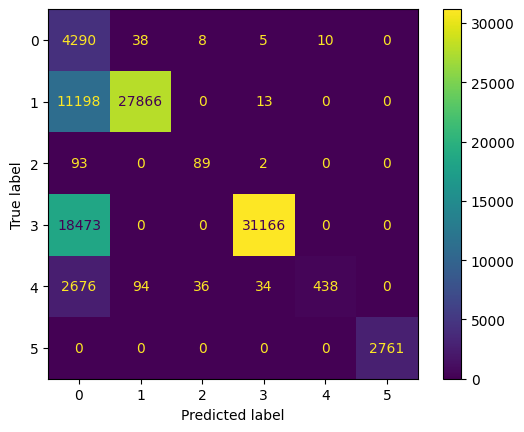

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_gnb = GaussianNB(var_smoothing = 1.873817422860383e-06)
# best_gnb.fit(x_train, y_train)

y_pred = best_gnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_gnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()

In [6]:
# mnb_org = MultinomialNB()
# mnb_org.fit(x_train, y_train)
# y_pred_mnb = mnb_org.predict(x_test)

# accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
# micro_f1_mnb = f1_score_rep(y_test, y_pred_mnb, average="micro")
# macro_f1_mnb = f1_score_rep(y_test, y_pred_mnb, average="macro")

# print(f'Multinomial Naive Bayes Test Accuracy: {accuracy_mnb * 100:.2f}%')
# print(f'Multinomial Naive Bayes Micro F1 Score: {micro_f1_mnb}')
# print(f'Multinomial Naive Bayes Macro F1 Score: {macro_f1_mnb}')

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
mnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100)  # alpha 值从 0 到 1
}

# # 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_mnb(x_train, y_train, param_grid):
    mnb = MultinomialNB()

    start = time()
    halving_mnb_results = HalvingGridSearchCV(
        mnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_mnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_mnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_mnb(x_val, y_val, mnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 MNB 模型
best_mnb = MultinomialNB(**best_params)
best_mnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_mnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_mnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_mnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


     iter  rank_test_score  mean_test_score                           params
200     6                2         0.537554                   {'alpha': 0.0}
199     6                4         0.537016  {'alpha': 0.010101010101010102}
198     5               23         0.532712                   {'alpha': 0.0}
197     5               24         0.532171  {'alpha': 0.010101010101010102}
196     5               25         0.532043  {'alpha': 0.020202020202020204}
Best score for HalvingGridSearchCV is 0.538, took 47.87 seconds
Params: {'alpha': 0.0}
Corresponding test accuracy: 46.03%
Micro F1 Score:  0.4602981166280592
Macro F1 Score:  0.3125211500172183


FPR: [0.30909321 0.00190989 0.01867697 0.09488228 0.11627713 0.06631168]
TPR: [0.87382211 0.70911278 0.2826087  0.23181369 0.14795607 0.77761681]
FNR: [0.12617789 0.29088722 0.7173913  0.76818631 0.85204393 0.22238319]
TNR: [0.69090679 0.99809011 0.98132303 0.90511772 0.88372287 0.93368832]
Precision: 0.3567030178316109
Accuracy: 0.4602981166280592
F1-score: 0.5224074682656568
AUC: 0.7919786827728634
FPR: 0.1011918591001506
tpr: 0.5038216923343591
fnr: 0.49617830766564075
tnr: 0.8988081408998494


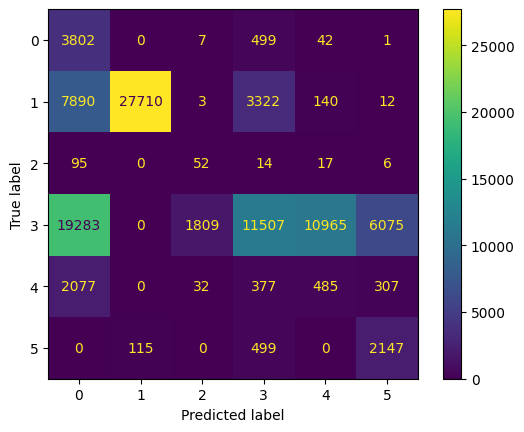

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_mnb = MultinomialNB(alpha= 0.0)
# best_mnb.fit(x_train, y_train)

y_pred = best_mnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_mnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()

In [9]:
# cnb_org = ComplementNB()
# cnb_org.fit(x_train, y_train)
# y_pred_cnb = cnb_org.predict(x_test)

# accuracy_cnb = accuracy_score(y_test, y_pred_cnb)
# micro_f1_cnb = f1_score_rep(y_test, y_pred_cnb, average="micro")
# macro_f1_cnb = f1_score_rep(y_test, y_pred_cnb, average="macro")

# print(f'Complement Naive Bayes Test Accuracy: {accuracy_cnb * 100:.2f}%')
# print(f'Complement Naive Bayes Micro F1 Score: {micro_f1_cnb}')
# print(f'Complement Naive Bayes Macro F1 Score: {macro_f1_cnb}')

In [10]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
cnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100)  # alpha 值从 0 到 1
}

# # 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_cnb(x_train, y_train, param_grid):
    cnb = ComplementNB()

    start = time()
    halving_cnb_results = HalvingGridSearchCV(
        cnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_cnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_cnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_cnb(x_val, y_val, cnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 CNB 模型
best_cnb = ComplementNB(**best_params)
best_cnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_cnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_cnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_cnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)

     iter  rank_test_score  mean_test_score                          params
199     6               18         0.617279  {'alpha': 0.36363636363636365}
200     6               19         0.617269                  {'alpha': 1.0}
195     5               14         0.617623  {'alpha': 0.20202020202020204}
196     5               14         0.617623  {'alpha': 0.21212121212121213}
197     5               14         0.617623  {'alpha': 0.36363636363636365}
Best score for HalvingGridSearchCV is 0.617, took 47.58 seconds
Params: {'alpha': 0.36363636363636365}
Corresponding test accuracy: 67.40%
Micro F1 Score:  0.6740255816295699
Macro F1 Score:  0.2644949364424896


FPR: [0.00288606 0.19296497 0.         0.41233812 0.         0.        ]
TPR: [0.0969892  0.71187655 0.         0.77930659 0.         0.        ]
FNR: [0.9030108  0.28812345 1.         0.22069341 1.         1.        ]
TNR: [0.99711394 0.80703503 1.         0.58766188 1.         1.        ]
Precision: 0.32760349325179877
Accuracy: 0.6740255816295699
F1-score: 0.6417342704050252
AUC: 0.6199907509208704
FPR: 0.10136485968370518
tpr: 0.26469539048591484
fnr: 0.735304609514085
tnr: 0.8986351403162948


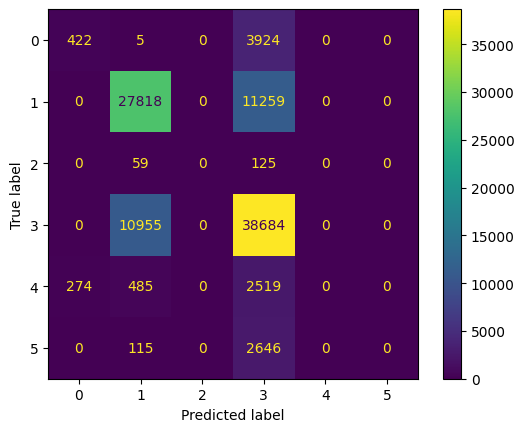

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_cnb = ComplementNB(alpha= 0.010101010101010102)
# best_cnb.fit(x_train, y_train)

y_pred = best_cnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_cnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()

In [12]:
# bnb_org = BernoulliNB()
# bnb_org.fit(x_train, y_train)
# y_pred_bnb = bnb_org.predict(x_test)

# accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
# micro_f1_bnb = f1_score_rep(y_test, y_pred_bnb, average="micro")
# macro_f1_bnb = f1_score_rep(y_test, y_pred_bnb, average="macro")

# print(f'Bernoulli Naive Bayes Test Accuracy: {accuracy_bnb * 100:.2f}%')
# print(f'Bernoulli Naive Bayes Micro F1 Score: {micro_f1_bnb}')
# print(f'Bernoulli Naive Bayes Macro F1 Score: {macro_f1_bnb}')

In [13]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
bnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100),  # alpha 值从 0 到 1
    'binarize': np.linspace(0.0, 1.0, num=20)  # binarize 阈值
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_bnb(x_train, y_train, param_grid):
    bnb = BernoulliNB()

    start = time()
    halving_bnb_results = HalvingGridSearchCV(
        bnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_bnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_bnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_bnb(x_val, y_val, bnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 BNB 模型
best_bnb = BernoulliNB(**best_params)
best_bnb.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_bnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_bnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_bnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


      iter  rank_test_score  mean_test_score  \
3998    10             1194         0.732658   
3999    10             4000         0.493642   
3997     9             1203         0.731548   
3994     9             1204         0.731527   
3995     9             1204         0.731527   

                                                 params  
3998  {'alpha': 0.010101010101010102, 'binarize': 0....  
3999    {'alpha': 0.0, 'binarize': 0.10526315789473684}  
3997    {'alpha': 0.0, 'binarize': 0.10526315789473684}  
3994  {'alpha': 0.010101010101010102, 'binarize': 0....  
3995  {'alpha': 0.010101010101010102, 'binarize': 0....  
Best score for HalvingGridSearchCV is 0.733, took 142.29 seconds
Params: {'alpha': 0.010101010101010102, 'binarize': 0.05263157894736842}
Corresponding test accuracy: 64.75%
Micro F1 Score:  0.6474670158122671
Macro F1 Score:  0.3952862411263345


FPR: [0.30108807 0.00139505 0.03483139 0.04996878 0.00417656 0.        ]
TPR: [0.96759366 0.7131049  0.         0.62789339 0.16198902 0.18544006]
FNR: [0.03240634 0.2868951  1.         0.37210661 0.83801098 0.81455994]
TNR: [0.69891193 0.99860495 0.96516861 0.95003122 0.99582344 1.        ]
Precision: 0.6035630983232726
Accuracy: 0.6474670158122671
F1-score: 0.728378570797821
AUC: 0.8315974630730523
FPR: 0.06524330844470926
tpr: 0.4426701696691672
fnr: 0.5573298303308328
tnr: 0.9347566915552906


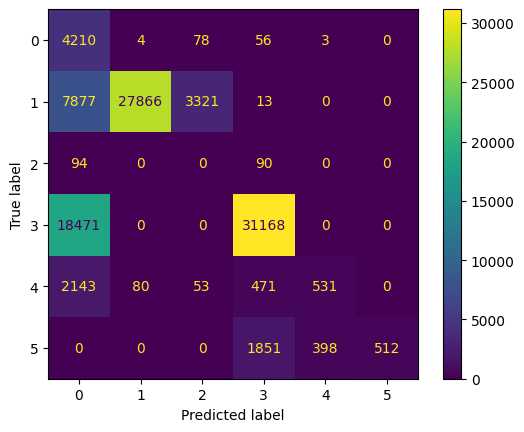

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_bnb = BernoulliNB(alpha=0.0, binarize=0.10526315789473684)
# best_bnb.fit(x_train, y_train)

y_pred = best_bnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_bnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_bnb.classes_)
disp.plot()
plt.show()

In [15]:
# ctnb_org = CategoricalNB()
# ctnb_org.fit(x_train, y_train)
# y_pred_ctnb = ctnb_org.predict(x_test)

# accuracy_ctnb = accuracy_score(y_test, y_pred_ctnb)
# micro_f1_ctnb = f1_score_rep(y_test, y_pred_ctnb, average="micro")
# macro_f1_ctnb = f1_score_rep(y_test, y_pred_ctnb, average="macro")

# print(f'Categorical Naive Bayes Test Accuracy: {accuracy_ctnb * 100:.2f}%')
# print(f'Categorical Naive Bayes Micro F1 Score: {micro_f1_ctnb}')
# print(f'Categorical Naive Bayes Macro F1 Score: {macro_f1_ctnb}')

In [19]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

# 请确保已经加载了 x_train, y_train, x_test, y_test, x_val, y_val

# 定义参数
ctnb_params = {
    'alpha': np.linspace(0.0, 1.0, num=100)  # alpha 值从 0 到 1
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Data/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_ctnb(x_train, y_train, param_grid):
    ctnb = CategoricalNB()

    start = time()
    halving_ctnb_results = HalvingGridSearchCV(
        ctnb,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_ctnb_results.cv_results_)
    # results.to_csv(result_dir / 'halving_ctnb_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_ctnb(x_val, y_val, ctnb_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 CTNB 模型
best_ctnb = CategoricalNB(**best_params)
best_ctnb.fit(x_train, y_train)

# # 在测试集上评估
accuracy = accuracy_score(y_test, best_ctnb.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_ctnb.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_ctnb.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


     iter  rank_test_score  mean_test_score                          params
199     6                1              NaN  {'alpha': 0.36363636363636365}
200     6                1              NaN                  {'alpha': 1.0}
195     5                1              NaN  {'alpha': 0.20202020202020204}
196     5                1              NaN  {'alpha': 0.21212121212121213}
197     5                1              NaN  {'alpha': 0.36363636363636365}
Best score for HalvingGridSearchCV is nan, took 26.41 seconds
Params: {'alpha': 0.36363636363636365}
Corresponding test accuracy: 83.36%
Micro F1 Score:  0.8335985497028905
Macro F1 Score:  0.6936011442206335


FPR: [8.24424104e-02 4.11206882e-02 1.13010312e-03 1.12485146e-01
 5.40557430e-03 3.10787432e-05]
TPR: [0.8409561  0.71760882 0.48369565 0.94494248 0.39993899 1.        ]
FNR: [0.1590439  0.28239118 0.51630435 0.05505752 0.60006101 0.        ]
TNR: [0.91755759 0.95887931 0.9988699  0.88751485 0.99459443 0.99996892]
Precision: 0.7148540362375327
Accuracy: 0.8335985497028905
F1-score: 0.8422253940011023
AUC: 0.9515846702072234
FPR: 0.04043583351715384
tpr: 0.7311903416252048
fnr: 0.26880965837479526
tnr: 0.9595641664828461


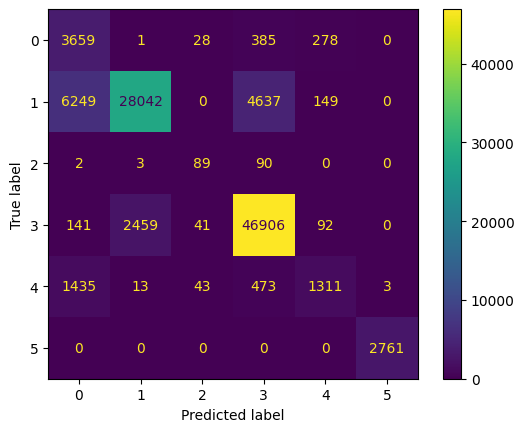

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_ctnb = CategoricalNB()
# best_ctnb.fit(x_train, y_train)

y_pred = best_ctnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_ctnb.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_gnb.classes_)
disp.plot()
plt.show()